In [1]:
import numpy as np 
import matplotlib.pyplot as plt
import scienceplots

In [2]:
#Definitions of the evolution of the alpha and beta coefficients used in the HH model

def an(v,vt):
    return -0.032 * (v-vt-15) / (np.exp(-(v-vt-15)/5)-1)

def bn(v,vt):
    return 0.5* np.exp(-(v-vt-10)/40)

def am(v,vt):

    return -0.32 * (v-vt-13) / (np.exp(-(v-vt-13)/4)-1)

def bm(v,vt):
    return 0.28 * (v-vt-40) / (np.exp((v-vt-40)/5) -1)

def ah(v,vt):
    return 0.128*np.exp(-(v-vt-17)/18)

def bh(v,vt):
    return 4 / (1+np.exp(-(v-vt-40)/5))


In [3]:
def HH_RK(y,order,gna,gk,gl,Ena,Ek,El,C,I,tau,k,v_neurons):
    '''
    Algorithm that calculates the changes in v, m, h, and n as per the HH model equations. It returns an np.array containing these changes
    '''
    Vrest = - 80 #because it's an inhibitory neuron
    vt = -58 
    Ina = gna * y[2]**3 * y[3] * (y[0] - Ena)
    Ik = gk * y[1]**4 * (y[0]- Ek)
    dvdt = (-Ina -Ik - gl * (y[0] - El) + I - k * np.sum(y[0] - v_neurons) -y[4] * (y[0] - Vrest)) / C 

    dmdt = am(y[0],vt) * (1-y[2]) - bm(y[0],vt) * y[2]
    dhdt = ah(y[0],vt) * (1-y[3]) - bh(y[0],vt) * y[3]
    dndt = an(y[0],vt) * (1-y[1]) - bn(y[0],vt) * y[1]
    y = np.append(y,0)
    for i in range(4,4+order):
        y[i] =  -y[i] / tau + y[i+1] 

    dydt = [dvdt,dndt,dmdt,dhdt]
    dydt = np.array(dydt,dtype=object)
    for i in range(4,4+order):
        dydt = np.append(dydt,float(y[i]))

    return dydt

In [4]:
def IF_RK(y,order,gl,El,C,I,tau,k,v_neurons):
    '''
    Algorithm that integrates the LIF model, returning the float dydt, the change in the signal
    '''
    Vrest = -80
    dvdt = (-gl * (y[0] - El) + I - k * np.sum(y[0] - v_neurons) - y[1]* (y[0] - Vrest)) / C  

    y = np.append(y,0)

    for i in range(1,1+order):
        y[i] =  -y[i] / tau + y[i+1]
    dydt = [dvdt]
    dydt = np.array(dydt,dtype=object)

    for i in range(1,1+order):
        dydt = np.append(dydt,float(y[i]))

    return dydt


In [11]:
def rk_Icst(dt, t_final, order, y0, n0, m0, h0, gna, gk, gl, Ena, Ek, El, C, I, Isyn, strength, tau):
    ''' 
    Runge Kutta integration of the HH model for the case of a single intensity, the following function has the more complete approeach
    '''
    Nsteps = int(t_final/dt)

    if type(y0) is int:
        y0 = [y0]
        n0 = [n0]
        m0 = [m0]
        h0 = [h0]
        I = [I]
    num_neurons = len(y0)
    if order > 5: #why?
        order = 5

    Y = np.zeros((Nsteps,num_neurons*(4+order)))
    end = num_neurons * (4+order) -1
    for i in range (0,num_neurons): #assign the initial values
        Y[0,i*(4+order)] = y0[i]
        Y[0,1+i*(4+order)] = n0[i]
        Y[0,2+i*(4+order)] = m0[i]
        Y[0,3+i*(4+order)] = h0[i]
    
    for i in range(0,Nsteps-1):
        for k in range(0,num_neurons):
            k1 = HH_RK(Y[i, k*(4+order): (k+1) * (4+order)], order, gna, gk, gl, Ena, Ek, El, C, I[k], tau, strength, Y[i, 0:end:4+order] )
            #print('k1',k1) a[0:4+1:4+1]
            k2 = HH_RK(Y[i, k*(4+order): (k+1) * (4+order)] + 0.5*dt*k1, order, gna, gk, gl, Ena, Ek, El, C, I[k], tau, strength, Y[i, 0:end:4+order ] )
            #print('k2',k2)
            k3 = HH_RK(Y[i, k*(4+order): (k+1) * (4+order)] + 0.5*dt*k2, order, gna, gk, gl, Ena, Ek, El, C, I[k], tau, strength, Y[i, 0:end:4+order ] )
            
            k4 = HH_RK(Y[i, k*(4+order): (k+1) * (4+order)] + dt * k3, order, gna, gk, gl, Ena, Ek, El, C, I[k], tau, strength, Y[i, 0:end:4+order ] )
            

            Y[i + 1, k * (4 + order): (k+1) *(4+order)] = Y[i, k * (4+order): (k+1)*(4+order)] + 1/6 * dt * (k1 + 2*k2 + 2*k3 + k4)

        for k in range(0,num_neurons):
            if i>0 and ( Y[i, k*(4+order)] >= Y [i-1,k*(4+order)]) and (Y[i,k*(4+order)] >= Y[i+1,k*(4+order)]) and Y[i,k*(4+order)] > 0:
                for l in range(0,num_neurons):
                    if l != k:
                        Y[i+1,l*(4+order) + 4 + order-1] = Y[i+1,l * (4+order) +4 + order-1] + Isyn[k,l]
    return Y

In [9]:
def rk_simplemodel(dt, t_final, order, y0, n0, m0, h0, gna, gk, gl, Ena, Ek, El, C, I, Isyn, strength, tau):
    ''' 
    Runge Kutta integration of the 4th order of the HH model, for various orders and numbers of neurons
    '''
    Nsteps = int(t_final/dt)

    if type(y0) is int:
        y0 = [y0]
        n0 = [n0]
        m0 = [m0]
        h0 = [h0]
        I = [I]
    num_neurons = len(y0)
    if order > 5:
        order = 5

    Y = np.zeros((Nsteps,num_neurons*(4+order)))
    end = num_neurons * (4+order) -1
    for i in range (0,num_neurons): #assign the initial values
        Y[0,i*(4+order)] = y0[i]
        Y[0,1+i*(4+order)] = n0[i]
        Y[0,2+i*(4+order)] = m0[i]
        Y[0,3+i*(4+order)] = h0[i]
    
    for i in range(0,Nsteps-1):
        for k in range(0,num_neurons):
            k1 = HH_RK(Y[i, k*(4+order): (k+1) * (4+order)], order, gna, gk, gl, Ena, Ek, El, C, I[i,k], tau, strength, Y[i, 0:end:4+order] )
            #print('k1',k1) a[0:4+1:4+1]
            k2 = HH_RK(Y[i, k*(4+order): (k+1) * (4+order)] + 0.5*dt*k1, order, gna, gk, gl, Ena, Ek, El, C, I[i,k], tau, strength, Y[i, 0:end:4+order ] )
            #print('k2',k2)
            k3 = HH_RK(Y[i, k*(4+order): (k+1) * (4+order)] + 0.5*dt*k2, order, gna, gk, gl, Ena, Ek, El, C, I[i,k], tau, strength, Y[i, 0:end:4+order ] )
            
            k4 = HH_RK(Y[i, k*(4+order): (k+1) * (4+order)] + dt * k3, order, gna, gk, gl, Ena, Ek, El, C, I[i,k], tau, strength, Y[i, 0:end:4+order ] )
            

            Y[i + 1, k * (4 + order): (k+1) *(4+order)] = Y[i, k * (4+order): (k+1)*(4+order) ] + 1/6 * dt * (k1 + 2*k2 + 2*k3 + k4)

        for k in range(0,num_neurons):
            if i>0 and ( Y[i, k*(4+order)] >= Y [i-1,k*(4+order)]) and (Y[i,k*(4+order)] >= Y[i+1,k*(4+order)]) and Y[i,k*(4+order)] > 0:
                for l in range(0,num_neurons):
                    if l != k:
                        Y[i+1,l*(4+order) + 4 + order-1] = Y[i+1,l * (4+order) +4 + order-1] + Isyn[k,l]
    return Y

In [7]:
def rk_if(dt,t_final,order,y0,Vth,Vr,w,gl,El,C,I,Isyn,strength,tau,spikelet):
    ''' 
    Runge-Kutta integration of the 4th order of the LIF model
    '''
    Nsteps = int(t_final/dt)
    if type(y0) is int:
        y0 = [y0]
        I = [I]
    num_neurons =len(y0)

    if order >5:
        order = 5
    
    Y = np.zeros( (Nsteps, num_neurons * (1 + order)))
    data = np.zeros((Nsteps, num_neurons))
    data[0,:] = y0 
    end = num_neurons * (1 + order) -1

    for i in range(0,num_neurons):
        Y[0, i * (1+order)] = y0[i]
    
    for i in range(0,Nsteps-1):
        for k in range(0,num_neurons):
            k1 = IF_RK( Y[i,k*(1+order):(k+1)*(1+order)] ,order,gl,El,C,I[i,k],tau,strength,Y[i,0:end:1+order])
            k2 = IF_RK( Y[i,k*(1+order):(k+1)*(1+order)] +0.5 * dt * k1,order,gl,El,C,I[i,k],tau,strength,Y[i,0:end:1+order])
            k3 = IF_RK( Y[i,k*(1+order):(k+1)*(1+order)] +0.5 * dt * k2,order,gl,El,C,I[i,k],tau,strength,Y[i,0:end:1+order])
            k4 = IF_RK( Y[i,k*(1+order):(k+1)*(1+order)] + dt * k3,order,gl,El,C,I[i,k],tau,strength,Y[i,0:end:1+order])

            Y[i+1,k*(1+order):(k+1)*(1+order)] = Y[i,k*(1+order):(k+1)*(1+order)] + (1/6)*dt*(k1+2*k2+2*k3+k4)

        for k in range(0,num_neurons):
            if Y[i+1,k * (1+order)] >= Vth:
                data[i+1,k] = w 
                Y[i+1, k * (1+order)] = Vr 
                for l in range(0,num_neurons):
                    if l != k:
                        Y[i+1,l * (1+order) +order] = Y[i+1,l*(1+order) + order] + Isyn[k,l]
                        Y[i+1,l * (1+order)] = Y[i+1,l *(1+order)] + spikelet
            else:
                data[i+1,k] = Y[i+1,k *(1+order)]
    return data, Y


# H-H model

Let's begin by the parameters

In [6]:
gna = 30
gk = 5 
gl = 0.1
Ena = 30
Ek = -90
El = -70 
C = 1


I = 2.5
Isyn = 0
k = 0
tau = 0.5 

V0 = -65
n0 = 0
m0 = 0
h0 = 0

dt = 0.01 
t_final = 200



Text(0.5, 1.0, 'Action potential with Runge-Kutta 4th order method for the H-H model')

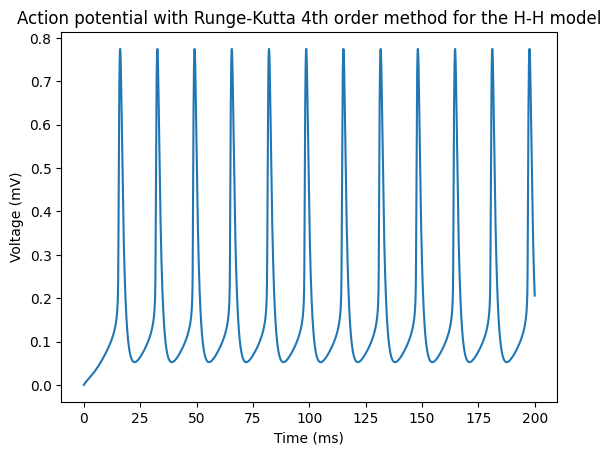

In [14]:
dataHH = rk_Icst(dt,t_final,1,V0,n0,m0,h0,gna,gk,gl,Ena,Ek,El,C,I,Isyn,k,tau)
tHH = np.linspace(0,t_final,int(t_final/dt))
plt.plot(tHH,dataHH[:,1])
plt.xlabel('Time (ms)')
plt.ylabel('Voltage (mV)')
plt.title('Action potential with Runge-Kutta 4th order method for the H-H model')

#### Results from 2a

First, we have to set the parameters

In [10]:
k = 0.012 #strength of the gap junction coupling
Isyn = [ [0, 0.05] , [0, 0.05]] #delta peak of the chemical synapse
tau = 1 #time constant for the chemical coupling equations

Define the time range and the initial conditions

In [11]:
V0 = -70
n0 =0.2
m0 = 0.1
h0 = 0.6 
dt = 0.01
t_final = 300

Inisitalisation of the input current for the first neuron ( we can do the same for a negative current)

In [12]:
I1 = np.zeros((int(t_final/dt),2))
I2 = np.zeros((int(t_final/dt),2))

for i in range(4999,15000):
    I1[i,0] =1
    I2[i,0] = -1

data2aHH = rk_simplemodel(dt,t_final,2,[V0,V0],[n0,n0],[m0,m0],[h0,h0],gna,gk,gl,Ena,Ek,El,C,I1,Isyn,k,tau)
data2 = rk_simplemodel(dt,t_final,2,[V0,V0],[n0,n0],[m0,m0],[h0,h0],gna,gk,gl,Ena,Ek,El,C,I2,Isyn,k,tau)

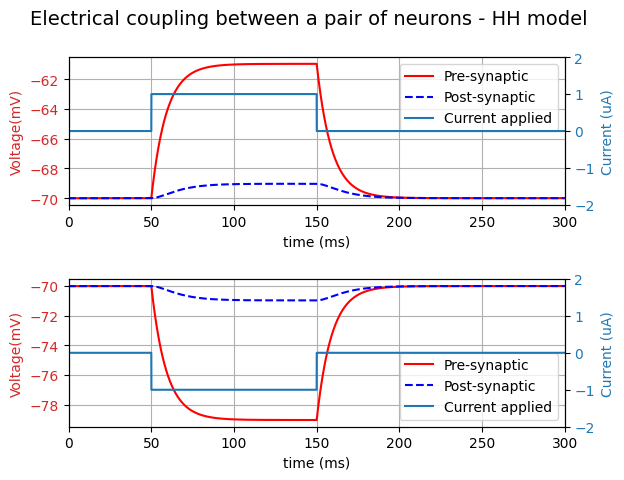

In [13]:
time = np.linspace(0,t_final,int(t_final/dt))

fig, (ax1, ax2) = plt.subplots(2,1) 

fig.subplots_adjust(hspace=0.5)
color = 'tab:red'
ax1.set_xlabel('time (ms)')
ax2.set_xlabel('time (ms)')

ax1.set_ylabel('Voltage(mV)', color = color)
ax2.set_ylabel('Voltage(mV)', color = color)
ax1.tick_params(axis = 'y', labelcolor = color)
ax2.tick_params(axis = 'y', labelcolor = color)

ax3 = ax1.twinx()
ax4 = ax2.twinx() 

color = 'tab:blue'

ax3.set_ylabel('Current (uA)', color = color)
ax4.set_ylabel('Current (uA)', color = color)
ax3.tick_params(axis = 'y', labelcolor = color)
ax4.tick_params(axis = 'y', labelcolor = color)



fig.suptitle('Electrical coupling between a pair of neurons - HH model',fontsize=14)

ax3.set_ylim(-2,2)
ax4.set_ylim(-2,2)
ax1.set_xlim(0,300)
ax2.set_xlim(0,300)
lns1 = ax1.plot(time,data2aHH[:,0], label = 'Pre-synaptic', color = 'r')
lns2 = ax1.plot(time,data2aHH[:,6], 'b--',label = 'Post-synaptic' )
lns3 = ax3.plot(time,I1[:,0], label = 'Current applied', color = 'tab:blue')


lns = lns1 + lns2 + lns3
labs = [l.get_label() for l in lns]
ax1.legend(lns,labs,loc = 0)

lns1 = ax2.plot(time,data2[:,0], label = 'Pre-synaptic', color = 'r')
lns2 = ax2.plot(time,data2[:,6], 'b--',label = 'Post-synaptic')
lns3 = ax4.plot(time,I2[:,0], label = 'Current applied', color = 'tab:blue')

lns = lns1 + lns2 + lns3
labs = [l.get_label() for l in lns]
ax2.legend(lns,labs,loc = 0)

ax1.grid()
ax2.grid()

plt.show()

Gap junction transmission. Looking for a transmission strength of around 0.1

C:\Users\pablo\AppData\Local\Temp\ipykernel_20052\4163484358.py:4: RuntimeWarning: invalid value encountered in divide
  gj_transmission = deltav2 / deltav1


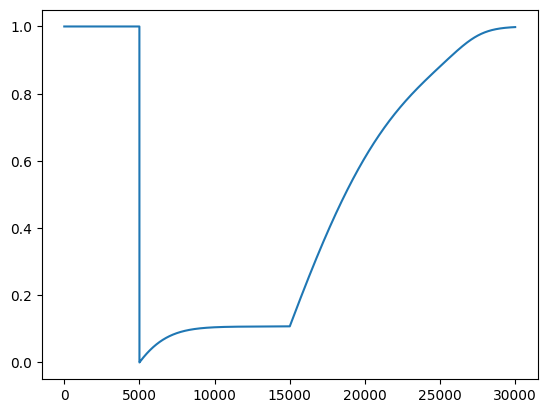

In [14]:
variationHHgj = np.zeros((len(data2aHH[:,0]),1))
deltav1 = np.array(abs(El-data2aHH[:,0]))
deltav2 = np.array(abs(El-data2aHH[:,6]))
gj_transmission = deltav2 / deltav1
variationHHgj[:,0] = gj_transmission
plt.plot(variationHHgj)

#### Result from 4Aa

Define the time range and initial conditions

In [15]:
V0 = -70 
n0 = 0.2
m0 = 0.1 
h0 = 0.6 
dt = 0.01 
t_final = 100

I = np.zeros((int(t_final/dt),2))
t = np.linspace(0,t_final,int(t_final/dt))
I[:,0] = -1 + np.sin(2 * np.pi * 0.04 * t) #t in ms, so f in Hz 

data = rk_simplemodel(dt,t_final,1,[V0,V0],[n0,n0],[m0,m0],[h0,h0],gna,gk,gl,Ena,Ek,El,C,I,Isyn,k,tau)

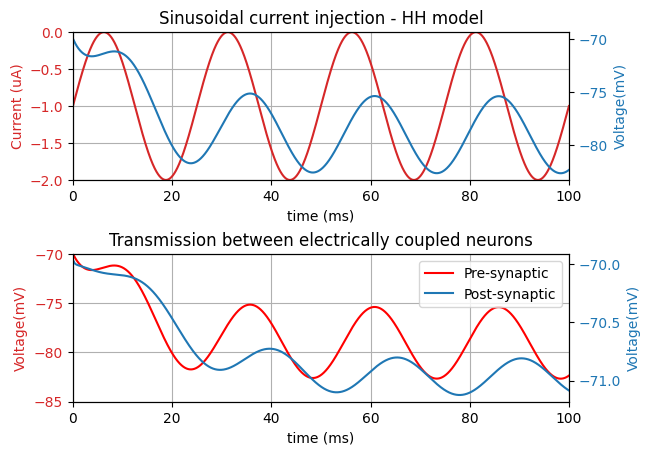

In [16]:
time = np.linspace(0,t_final,int(t_final/dt))

fig, (ax1, ax2) = plt.subplots(2,1) 

fig.subplots_adjust(hspace=0.5)
color = 'tab:red'
ax1.set_xlabel('time (ms)')
ax2.set_xlabel('time (ms)')

ax1.set_ylabel('Current (uA)', color = color)
ax2.set_ylabel('Voltage(mV)', color = color)
ax1.tick_params(axis = 'y', labelcolor = color)
ax2.tick_params(axis = 'y', labelcolor = color)

ax3 = ax1.twinx()
ax4 = ax2.twinx() 

color = 'tab:blue'

ax3.set_ylabel('Voltage(mV)', color = color)
ax4.set_ylabel('Voltage(mV)', color = color)
ax3.tick_params(axis = 'y', labelcolor = color)
ax4.tick_params(axis = 'y', labelcolor = color)



ax1.title.set_text('Sinusoidal current injection - HH model')
ax2.title.set_text('Transmission between electrically coupled neurons')

ax1.set_ylim(-2,0)
ax2.set_ylim(-85,-70)
ax1.set_xlim(0,100)
ax2.set_xlim(0,100)
lns1 = ax1.plot(time,I[:,0], color = 'tab:red')
lns3 = ax3.plot(time,data[:,0], color = 'tab:blue')


lns1 = ax2.plot(time,data[:,0], label = 'Pre-synaptic', color = 'r')
lns3 = ax4.plot(time,data[:,5], label = 'Post-synaptic', color = 'tab:blue')

lns = lns1 + lns3
labs = [l.get_label() for l in lns]
ax2.legend(lns,labs,loc = 0)

ax1.grid()
ax2.grid()

plt.show()

#### Result from 4Ab

In [17]:
t_final = 1000
I = np.zeros((int(t_final/dt),2))
t = np.linspace(0,t_final,int(t_final/dt))

f_log = np.linspace(-3,-1,int(2/0.1))
f = 10**f_log
mean = np.zeros((len(f),1))


for i in range(0,len(f)):
    I[:,0] = -1 + np.sin(2 * np.pi * f[i] * t)
    data = rk_simplemodel(dt,t_final,1,[V0,V0],[n0,n0],[m0,m0],[h0,h0],gna,gk,gl,Ena,Ek,El,C,I,Isyn,k,tau)
    end = len(data)
    if i < 9:
        mean[i] = ( np.max(data[10000:end-1,5]) - np.min(data[10000:end-1,5]) ) / ( np.max(data[10000:end-1,0]) - np.min(data[10000:end-1,0]) )
    else:
        mean[i] = ( np.max(data[80000:end-1,5]) - np.min(data[80000:end-1,5]) ) / ( np.max(data[80000:end-1,0]) - np.min(data[80000:end-1,0]) )

f = 1000*f 
mean = mean * 100 
for i in range(1,len(f)):
    mean[i] = mean[i] * 100 / mean[0]

mean[0] = 100

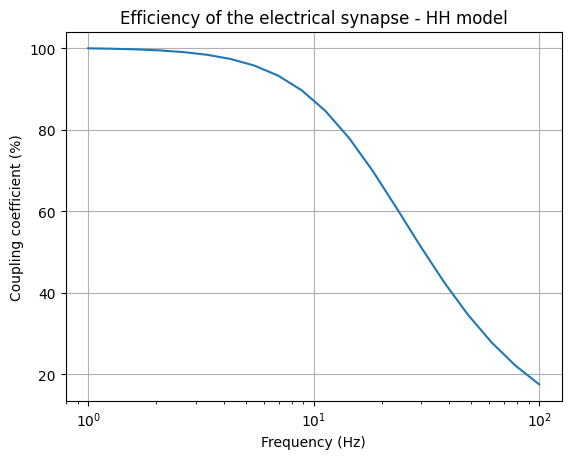

In [18]:
fHH = f
meanHH = mean 
plt.plot(f,mean)
plt.xscale('log')
plt.title('Efficiency of the electrical synapse - HH model')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Coupling coefficient (%)')
plt.grid()

#### Results from 4B

Switch off synaptic coupling

In [19]:
Isyn = np.zeros(([2 , 2 ]))
I = [4, 0]

Define the time range and initial conditions

In [20]:
V0 = -65 
n0 = 0.2
m0 = 0.1
h0 =0.6
dt =0.01
t_final = 100 

dataHH = rk_Icst(dt,t_final,5,[V0,V0],[n0,n0],[m0,m0],[h0,h0],gna,gk,gl,Ena,Ek,El,C,I,Isyn,k,tau)

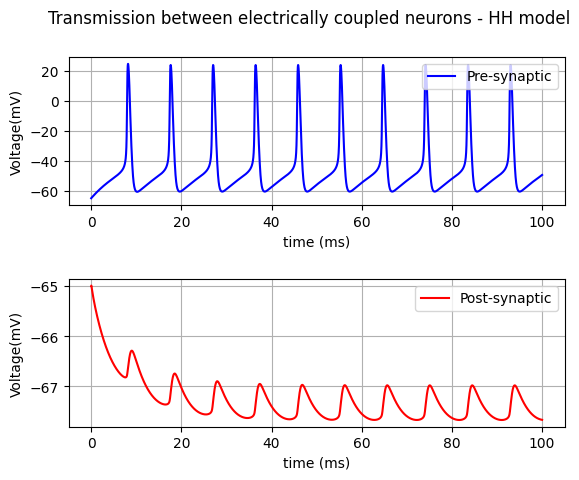

In [23]:
time = np.linspace(0,t_final,int(t_final/dt))

fig, (ax1, ax2) = plt.subplots(2,1) 

fig.subplots_adjust(hspace=0.5)
ax1.set_xlabel('time (ms)')
ax2.set_xlabel('time (ms)')

ax1.set_ylabel('Voltage(mV)')
ax2.set_ylabel('Voltage(mV)')


plt.suptitle('Transmission between electrically coupled neurons - HH model')


ax1.plot(time,dataHH[:,0], color = 'b', label = 'Pre-synaptic')


ax2.plot(time,dataHH[:,9], label = 'Post-synaptic', color = 'r')

ax1.legend(loc='upper right')
ax2.legend()
ax1.grid()
ax2.grid()

plt.show()

#### Result from 6

In [28]:
Isyn = np.zeros(([2 , 2 ]))
tau = 0.3

Define the time range and initial conditions

In [31]:
V0 = -60
n0 = 0.2 
m0 = 0.1 
h0 = 0.6 
dt = 0.01
t_final =200 

I = np.zeros((int(t_final/dt), 2))

x1 = np.random.normal(0,5,int(t_final/dt))
x2 = np.random.normal(0,5,int(t_final/dt))

I[:,0] = 2 + 5 *x1 
I[:,1] = 1.5 + 5*x2 
data = rk_simplemodel(dt, t_final,5,[V0,V0],[n0,n0],[m0,m0],[h0,h0],gna,gk,gl,Ena,Ek,El,C,I,Isyn,k,tau)

Plot to visualise the effect on the post-synaptic neuron potential

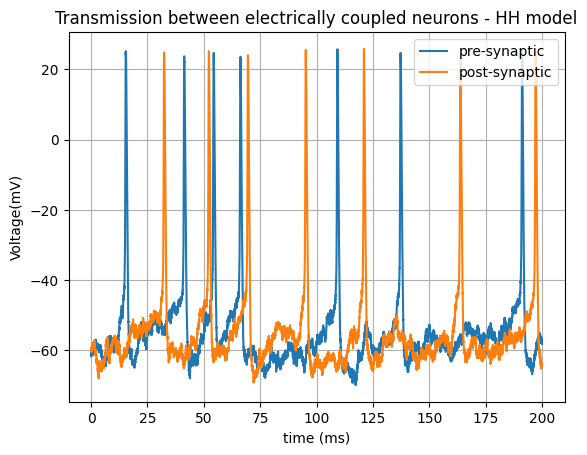

In [32]:
t = np.linspace(0,t_final,int(t_final/dt))
plt.plot(t,data[:,0], label = 'pre-synaptic')
plt.plot(t,data[:,9], label = 'post-synaptic')
plt.title('Transmission between electrically coupled neurons - HH model')
plt.xlabel('time (ms)')
plt.ylabel('Voltage(mV)')
plt.grid()
plt.legend(loc= 'upper right')

# Integrate and Fire model

Now we will try to reproduce the results with the IF model.

Define the parameters

In [33]:
C = 1
El = -70
gl = 0.1 
Vth = -49.2 
Vr = -66.9 
w = 25
k = 0.012
tau = 1
Is = [[0, 0.05], [0.05, 0]]
step = 0.01 
order = 2

#### Results from 2Ab

Then, we can define the time range and the initial conditions

In [34]:
y0 = [-70, -70]
dt = 0.01 
t_final = 300
I1 = np.zeros((int(t_final/dt),2))
I2 = np.zeros((int(t_final/dt),2))

for i in range(4999,15000):
    I1[i,0] = 1
    I2[i,0] = -1

data2aIF, s1 = rk_if(dt,t_final,order,y0,Vth,Vr,w,gl,El,C,I1,Is,k,tau,1)
data2, s2 = rk_if(dt,t_final,order,y0,Vth,Vr,w,gl,El,C,I2,Is,k,tau,1)

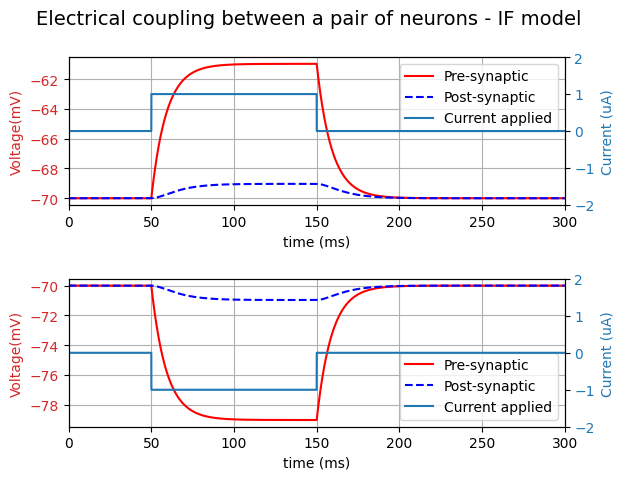

In [35]:
time = np.linspace(0,t_final,int(t_final/dt))

fig, (ax1, ax2) = plt.subplots(2,1) 

fig.subplots_adjust(hspace=0.5)
color = 'tab:red'
ax1.set_xlabel('time (ms)')
ax2.set_xlabel('time (ms)')

ax1.set_ylabel('Voltage(mV)', color = color)
ax2.set_ylabel('Voltage(mV)', color = color)
ax1.tick_params(axis = 'y', labelcolor = color)
ax2.tick_params(axis = 'y', labelcolor = color)

ax3 = ax1.twinx()
ax4 = ax2.twinx() 

color = 'tab:blue'

ax3.set_ylabel('Current (uA)', color = color)
ax4.set_ylabel('Current (uA)', color = color)
ax3.tick_params(axis = 'y', labelcolor = color)
ax4.tick_params(axis = 'y', labelcolor = color)



fig.suptitle('Electrical coupling between a pair of neurons - IF model',fontsize=14)

ax3.set_ylim(-2,2)
ax4.set_ylim(-2,2)
ax1.set_xlim(0,300)
ax2.set_xlim(0,300)
lns1 = ax1.plot(time,data2aIF[:,0], label = 'Pre-synaptic', color = 'r')
lns2 = ax1.plot(time,data2aIF[:,1], 'b--',label = 'Post-synaptic' )
lns3 = ax3.plot(time,I1[:,0], label = 'Current applied', color = 'tab:blue')


lns = lns1 + lns2 + lns3
labs = [l.get_label() for l in lns]
ax1.legend(lns,labs,loc = 0)

lns1 = ax2.plot(time,data2[:,0], label = 'Pre-synaptic', color = 'r')
lns2 = ax2.plot(time,data2[:,1], 'b--',label = 'Post-synaptic')
lns3 = ax4.plot(time,I2[:,0], label = 'Current applied', color = 'tab:blue')

lns = lns1 + lns2 + lns3
labs = [l.get_label() for l in lns]
ax2.legend(lns,labs,loc = 0)

ax1.grid()
ax2.grid()

plt.show()

Gap junction transmission

C:\Users\pablo\AppData\Local\Temp\ipykernel_20052\2056632761.py:4: RuntimeWarning: invalid value encountered in divide
  gj_transmission = deltav2 / deltav1


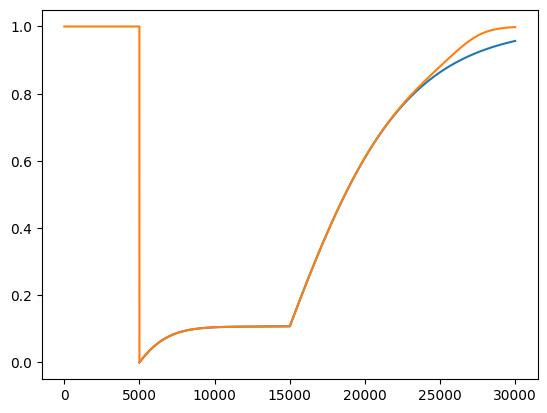

In [36]:
variationLIFgj = np.zeros((len(data2aIF[:,0]), 1))
deltav1 = np.array(abs(El - data2aIF[:,0]))
deltav2 = np.array(abs(El - data2aIF[:,1]))
gj_transmission = deltav2 / deltav1
variationLIFgj[:,0] = gj_transmission

plt.plot(variationLIFgj)
plt.plot(variationHHgj)

#### Result from 4Aa

In [37]:
Is = [ [0, 0.05], [0.05, 0]]

Define the time range and initial conditions

In [38]:
y0 = [-70, -70]
dt = 0.01 
t_final = 100

I = np.zeros(( int(t_final/dt), 2))
t = np.linspace(0,t_final, int(t_final/dt))
I[:,0] = np.sin(2* np.pi * 0.04 * t)

data, s = rk_if(dt, t_final,order,y0,Vth,Vr,w,gl,El,C,I,Is,k,tau,1)

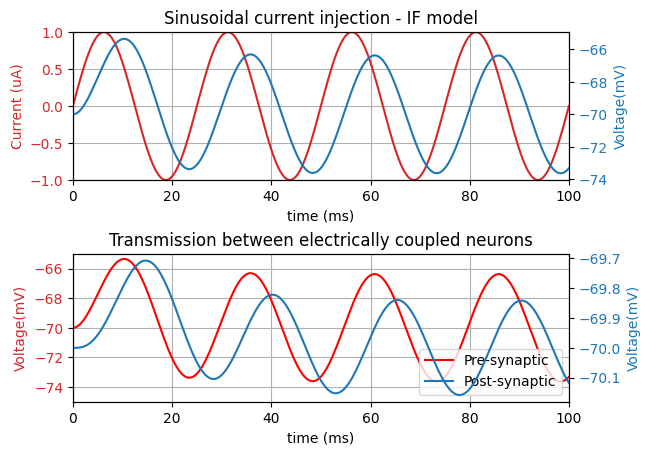

In [41]:
time = np.linspace(0,t_final,int(t_final/dt))

fig, (ax1, ax2) = plt.subplots(2,1) 

fig.subplots_adjust(hspace=0.5)
color = 'tab:red'
ax1.set_xlabel('time (ms)')
ax2.set_xlabel('time (ms)')

ax1.set_ylabel('Current (uA)', color = color)
ax2.set_ylabel('Voltage(mV)', color = color)
ax1.tick_params(axis = 'y', labelcolor = color)
ax2.tick_params(axis = 'y', labelcolor = color)

ax3 = ax1.twinx()
ax4 = ax2.twinx() 

color = 'tab:blue'

ax3.set_ylabel('Voltage(mV)', color = color)
ax4.set_ylabel('Voltage(mV)', color = color)
ax3.tick_params(axis = 'y', labelcolor = color)
ax4.tick_params(axis = 'y', labelcolor = color)



ax1.title.set_text('Sinusoidal current injection - IF model')
ax2.title.set_text('Transmission between electrically coupled neurons')

ax1.set_ylim(-1,1)
ax2.set_ylim(-75,-65)
ax1.set_xlim(0,100)
ax2.set_xlim(0,100)
lns1 = ax1.plot(time,I[:,0], color = 'tab:red')
lns3 = ax3.plot(time,data[:,0], color = 'tab:blue')


lns1 = ax2.plot(time,data[:,0], label = 'Pre-synaptic', color = 'r')
lns3 = ax4.plot(time,data[:,1], label = 'Post-synaptic', color = 'tab:blue')

lns = lns1 + lns3
labs = [l.get_label() for l in lns]
ax2.legend(lns,labs, loc = 'lower right')

ax1.grid()
ax2.grid()

plt.show()

#### Results from 4Ab

In [42]:
t_final = 1000
I = np.zeros((int(t_final/dt),2))
t = np.linspace(0,t_final,int(t_final/dt))

f_log = np.linspace(-3,-1,int(2/0.1))
f = 10**f_log
mean = np.zeros((len(f),1))


for i in range(0,len(f)):
    I[:,0] = np.sin(2 * np.pi * f[i] * t)
    data, s = rk_if(dt, t_final,order,y0,Vth,Vr,w,gl,El,C,I,Is,k,tau,1)
    end = len(data)
    if i < 9:
        mean[i] = ( np.max(data[:,1]) - np.min(data[:,1]) ) / ( np.max(data[:,0]) - np.min(data[:,0]) )
    else:
        mean[i] = ( np.max(data[80000:end-1,1]) - np.min(data[80000:end-1,1]) ) / ( np.max(data[80000:end-1,0]) - np.min(data[80000:end-1,0]) )

f = 1000*f 
mean = mean * 100 
for i in range(1,len(f)):
    mean[i] = mean[i] * 100 / mean[0]

mean[0] = 100

Plot to visualise the effect of the post-synaptic current potential

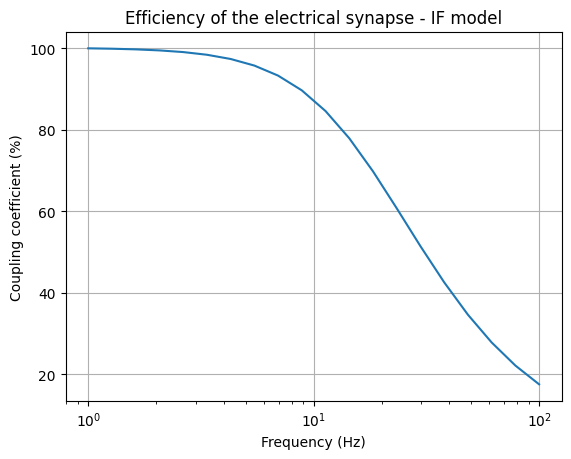

In [56]:
fIF= f 
meanIF = mean 
plt.plot(f,mean)
plt.xscale('log')
plt.title('Efficiency of the electrical synapse - IF model')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Coupling coefficient (%)')
plt.grid()

#### Results from 4B

Switch off synaptic coupling

In [43]:
Isyn = np.zeros((2 , 2 ))

Define the time range and the initial conditions

In [44]:
I = np.zeros((int(t_final/dt),2))
I[:,0] = 2.37

y0 = [-65 , -65]
dt=0.01
t_final=100

dataIF,s = rk_if(dt, t_final,order,y0,Vth,Vr,w,gl,El,C,I,Isyn,k,tau,1)

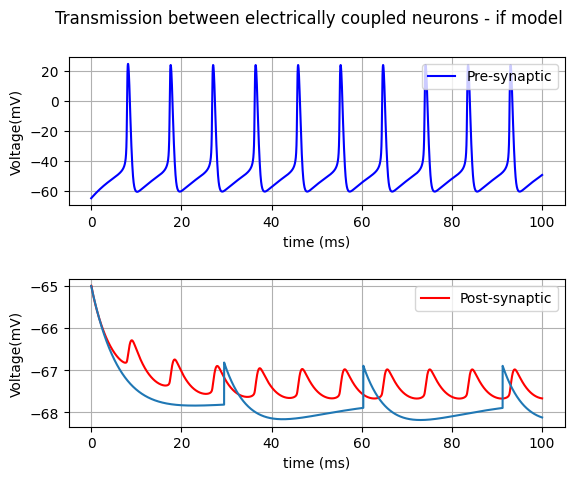

In [45]:
time = np.linspace(0,t_final,int(t_final/dt))

fig, (ax1, ax2) = plt.subplots(2,1) 

fig.subplots_adjust(hspace=0.5)
ax1.set_xlabel('time (ms)')
ax2.set_xlabel('time (ms)')

ax1.set_ylabel('Voltage(mV)')
ax2.set_ylabel('Voltage(mV)')


plt.suptitle('Transmission between electrically coupled neurons - if model')


ax1.plot(time,dataHH[:,0], color = 'b', label = 'Pre-synaptic')


ax2.plot(time,dataHH[:,9], label = 'Post-synaptic', color = 'r')
ax2.plot(time,dataIF[:,1])

ax1.legend(loc = 'upper right')
ax2.legend()
ax1.grid()
ax2.grid()

plt.show()

#### Results from 6

In [46]:
Is = np.array([ [0, 0.05], [0.05, 0]])
tau = 0.65

In [47]:
y0 = [-60, -60]
dt = 0.01
t_final = 200

I = np.zeros((int(t_final/dt), 2))

x1 = np.random.normal(0,5,int(t_final/dt))
x2 = np.random.normal(0,5,int(t_final/dt))

I[:,0] = 2 + 5 *x1 
I[:,1] = 1.5 + 5*x2 
data,s = rk_if(dt, t_final,order,y0,Vth,Vr,w,gl,El,C,I,Is,k,tau,0.7)

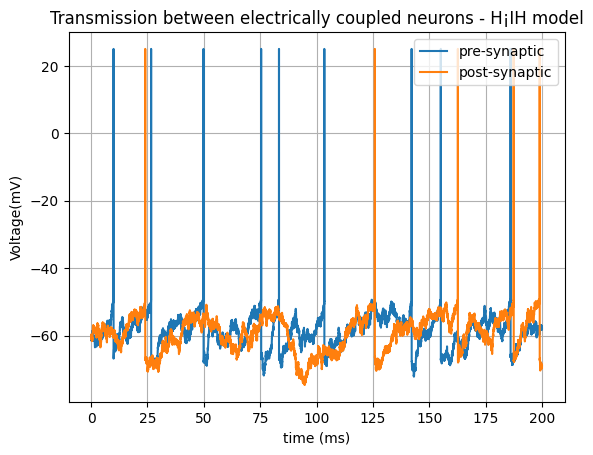

In [48]:
t = np.linspace(0,t_final,int(t_final/dt))
plt.plot(t,data[:,0], label = 'pre-synaptic')
plt.plot(t,data[:,1], label = 'post-synaptic')
plt.title('Transmission between electrically coupled neurons - H¡IH model')
plt.xlabel('time (ms)')
plt.ylabel('Voltage(mV)')
plt.grid()
plt.legend(loc = 'upper right')